In [14]:
# Import stuff
from torchvision import transforms, datasets, models
import os
from PIL import Image
import numpy as np
import platform
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torch.utils.data import DataLoader, random_split
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [8]:
# For running in colab
def in_colab() -> bool:
    try:
        import google.colab
        return True
    except Exception:
        return False

In [9]:
# Select device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"{torch.cuda.get_device_name(0)}")
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device.type}\n")
# Print the gpu model

NVIDIA A100-SXM4-40GB
Using device: cuda



## Prepare Dataset

In [10]:
# Find images that are the wrong shape
categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
dirs = []

if in_colab():
    from google.colab import drive
    !mkdir models
    drive.mount('/content/drive')
    dirs = ['/content/drive/MyDrive/2025-2026/Semester 1/MTH 4320/data/seg_test/seg_test/' + category for category in categories]
    dirs.extend(['/content/drive/MyDrive/2025-2026/Semester 1/MTH 4320/data/seg_train/seg_train/' + category for category in categories])
else:
    dirs = ['data/seg_test/seg_test/' + category for category in categories]
    dirs.extend(['data/seg_train/seg_train/' + category for category in categories])

counter = 0
for dir in dirs:
    for image in os.listdir(dir):
        image_path = os.path.join(dir, image)
        if image_path.endswith(('.jpg', 'jpeg', '.png')):
            img = Image.open(image_path)
            if img.size != (150, 150):
                os.remove(image_path)
                counter += 1
print(f"Images with wrong shape: {counter}") # originally 55
# 4 minutes on google colab

mkdir: cannot create directory ‘models’: File exists
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Images with wrong shape: 0


In [11]:
# Load data
if in_colab():
    dataset = datasets.ImageFolder(root="/content/drive/MyDrive/2025-2026/Semester 1/MTH 4320/data/seg_train/seg_train/", transform=transforms.ToTensor())
    test_dataset = datasets.ImageFolder(root="/content/drive/MyDrive/2025-2026/Semester 1/MTH 4320/data/seg_test/seg_test/", transform=transforms.ToTensor())
else:
    dataset = datasets.ImageFolder(root="data/seg_train/seg_train", transform=transforms.ToTensor())
    test_dataset = datasets.ImageFolder(root="data/seg_test/seg_test", transform=transforms.ToTensor())

print(f"Classes: {dataset.classes}")

# Split data
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

# Data loaders
batch_size = 128
print(f"Batch size: {batch_size}")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Train size: 11188
Val size: 2798
Test size: 2993
Batch size: 128


## Functions

In [6]:
# Calculate accuracy from logits
def accuracy_from_logits(logits, y):
    preds = logits.argmax(1)  # choose class with highest predicted score
    return (preds == y).float().mean().item()  # fraction of correct predictions

def train(name, model, optimizer, epochs, criterion, history):
    # Early stopping settings
    patience = 10          # epochs to wait after last improvement
    min_delta = 0.0        # minimum change in val_loss to qualify as improvement
    best_val = 10e20       # track best validation loss
    best_epoch = -1
    patience_ctr = 0
    best_ckpt_path = "best.pt"

    train_start_time = time.time()

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()

        # Training
        model.train()
        running_loss, running_correct, total = 0.0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)
            running_correct += (logits.argmax(1) == y).sum().item()
            total += x.size(0)

        train_loss = running_loss / total
        train_acc  = running_correct / total

        # Validation
        model.eval()
        val_running_loss, val_running_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                loss = criterion(logits, y)
                val_running_loss += loss.item() * x.size(0)
                val_running_correct += (logits.argmax(1) == y).sum().item()
                val_total += x.size(0)

        val_loss = val_running_loss / val_total
        val_acc  = val_running_correct / val_total

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch:02d} | "
            f"train: loss={train_loss:.4f}, acc={train_acc:.4f} | "
            f"val: loss={val_loss:.4f}, acc={val_acc:.4f} | "
            f"time: {epoch_time:.2f}s")

        # Early stopping check (monitor val_loss)
        if val_loss < best_val - min_delta:
            best_val = val_loss
            best_epoch = epoch
            patience_ctr = 0
            # Save best checkpoint so far
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "history": history,
                "best_val_loss": best_val
            }, best_ckpt_path)
            print(f"  -> New best val_loss {best_val:.4f} at epoch {epoch}. Saved to {best_ckpt_path}.")
        else:
            patience_ctr += 1
            if patience_ctr >= patience:
                print(f"\nEarly stopping triggered at epoch {epoch} "
                    f"(no improvement for {patience} epochs). Best epoch: {best_epoch}.")
                break

    # Total training time
    total_time = time.time() - train_start_time
    print(f"\nTotal training time: {total_time:.2f}s")
    print(f"Best epoch: {best_epoch} | Best val_loss: {best_val:.4f}")

    # Restore best model before final save (in case we stopped after it)
    ckpt = torch.load(best_ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])

    # Save final artifact (model + history)
    final_path = f"models/{name}.pth"
    if in_colab():
        final_path = f"/content/models/{name}.pth"
    torch.save({
        "model_state": model.state_dict(),
        "history": history,
        "best_epoch": best_epoch,
        "best_val_loss": best_val
    }, final_path)
    print(f"Final model saved to '{final_path}'")

def display_results(path, model):
    # Loss and accuracy graph
    # Load the trained model from file
    #model = MLP(128*128).to(device)  # initialize model structure
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    history = checkpoint["history"]

    model.eval()  # set to evaluation mode

    # Prepare x-axis for plots
    epochs = range(1, len(history["train_loss"]) + 1)

    # Create figure and first axis (loss)
    fig, ax1 = plt.subplots()

    color_loss = "tab:blue"
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color=color_loss)
    ax1.plot(epochs, history["train_loss"], label="Train Loss", color=color_loss, linestyle="-")
    ax1.plot(epochs, history["val_loss"], label="Val Loss", color=color_loss, linestyle="--")
    ax1.tick_params(axis="y", labelcolor=color_loss)

    # Second y-axis for accuracy
    ax2 = ax1.twinx()
    color_acc = "tab:orange"
    ax2.set_ylabel("Accuracy", color=color_acc)
    ax2.plot(epochs, history["train_acc"], label="Train Acc", color=color_acc, linestyle="-")
    ax2.plot(epochs, history["val_acc"], label="Val Acc", color=color_acc, linestyle="--")
    ax2.tick_params(axis="y", labelcolor=color_acc)

    # Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="center right")

    plt.title("Loss and Accuracy over Epochs")
    fig.tight_layout()
    plt.show()




    # Confusion matrix
    # Variables to track accuracy
    test_correct, test_total = 0, 0

    # Lists to store predictions and true labels for the confusion matrix
    all_preds, all_trues = [], []

    # Disable gradient computation for faster evaluation
    with torch.no_grad():
        # Loop through the test set in batches
        for x, y in test_loader:
            # Move inputs to the computation device (CPU/GPU/MPS)
            x = x.to(device)

            # Forward pass to get raw model outputs (logits)
            logits = model(x)

            # Get predicted class indices (highest logit per sample)
            preds = logits.argmax(1).cpu().numpy()

            # Store predictions and ground truth labels for later
            all_preds.append(preds)
            all_trues.append(y.numpy())

            # Update accuracy counters
            test_correct += (preds == y.numpy()).sum()
            test_total   += y.size(0)

    # Compute overall test accuracy
    test_acc = test_correct / test_total
    print(f"Test accuracy: {test_acc:.4f}")

    # Flatten predictions and true labels into 1D arrays
    y_true = np.concatenate(all_trues).ravel()
    y_pred = np.concatenate(all_preds).ravel()

    # Dynamically detect classes from both true and predicted
    class_labels = np.unique(np.concatenate((y_true, y_pred)))
    print(f"Detected {len(class_labels)} classes: {class_labels}")

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)

    # Plot annotated confusion matrix
    plt.figure(figsize=(6,6))
    sns.heatmap(
        cm,
        annot=True,              # annotate all cells
        fmt="d",                 # integer format
        cbar=True,
        xticklabels=class_labels,
        yticklabels=class_labels
    )
    plt.title("Confusion Matrix (Test)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

## 1st Model

Epoch 01 | train: loss=176.2827, acc=0.1735 | val: loss=1.7917, acc=0.1862 | time: 53.18s
  -> New best val_loss 1.7917 at epoch 1. Saved to best.pt.
Epoch 02 | train: loss=1.7914, acc=0.1731 | val: loss=1.7914, acc=0.1862 | time: 43.63s
  -> New best val_loss 1.7914 at epoch 2. Saved to best.pt.
Epoch 03 | train: loss=1.7915, acc=0.1734 | val: loss=1.7927, acc=0.1626 | time: 43.57s
Epoch 04 | train: loss=1.7914, acc=0.1747 | val: loss=1.7916, acc=0.1608 | time: 41.81s
Epoch 05 | train: loss=1.7916, acc=0.1662 | val: loss=1.7917, acc=0.1862 | time: 41.67s
Epoch 06 | train: loss=1.7913, acc=0.1731 | val: loss=1.7920, acc=0.1626 | time: 41.69s
Epoch 07 | train: loss=1.7914, acc=0.1750 | val: loss=1.7913, acc=0.1862 | time: 41.42s
  -> New best val_loss 1.7913 at epoch 7. Saved to best.pt.
Epoch 08 | train: loss=1.7914, acc=0.1744 | val: loss=1.7922, acc=0.1862 | time: 42.28s
Epoch 09 | train: loss=1.7914, acc=0.1741 | val: loss=1.7913, acc=0.1862 | time: 41.88s
  -> New best val_loss 1.7

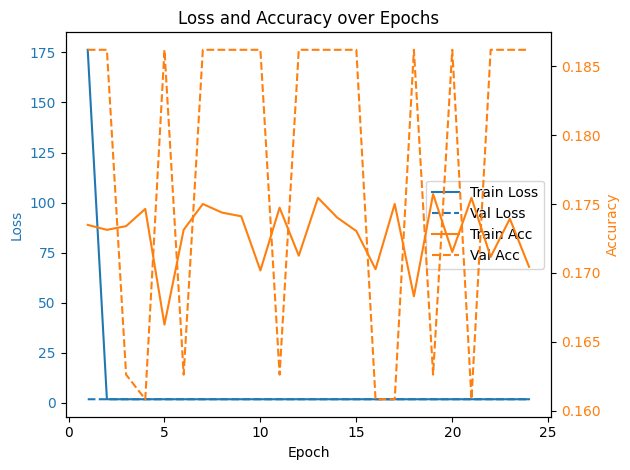

Test accuracy: 0.1747
Detected 6 classes: [0 1 2 3 4 5]


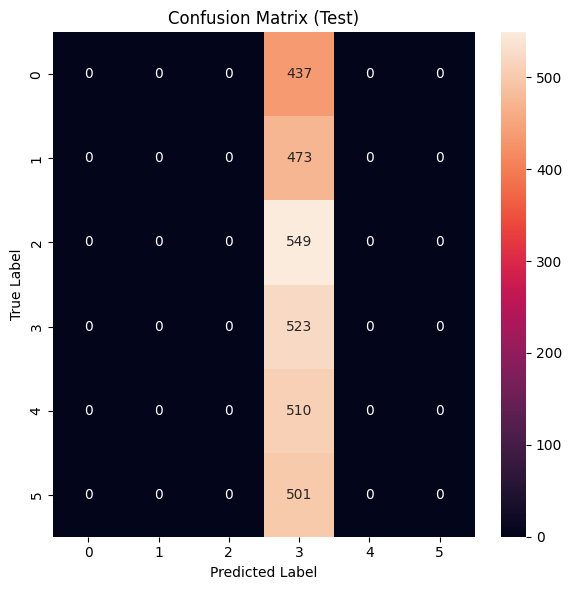

In [ ]:
class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(256 * 18 * 18, 512),
            nn.ReLU(),
            nn.Linear(512, 6)
        )
    def forward(self, x):
        return self.net(x)

name = "CNN1"
model = CNN1().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 100
criterion = nn.CrossEntropyLoss()
history = {
    "train_loss": [], "train_acc": [],
    "val_loss":   [], "val_acc":   []
}

train(name, model, optimizer, epochs, criterion, history)
display_results("models/CNN1.pth", model)

## 2nd Model

Epoch 01 | train: loss=1.3080, acc=0.5301 | val: loss=0.9129, acc=0.6197 | time: 41.37s
  -> New best val_loss 0.9129 at epoch 1. Saved to best.pt.
Epoch 02 | train: loss=0.8309, acc=0.6803 | val: loss=0.7921, acc=0.6812 | time: 42.86s
  -> New best val_loss 0.7921 at epoch 2. Saved to best.pt.
Epoch 03 | train: loss=0.6867, acc=0.7436 | val: loss=0.6115, acc=0.7773 | time: 42.72s
  -> New best val_loss 0.6115 at epoch 3. Saved to best.pt.
Epoch 04 | train: loss=0.5540, acc=0.7971 | val: loss=0.5807, acc=0.7856 | time: 42.69s
  -> New best val_loss 0.5807 at epoch 4. Saved to best.pt.
Epoch 05 | train: loss=0.4849, acc=0.8241 | val: loss=0.5133, acc=0.8034 | time: 42.71s
  -> New best val_loss 0.5133 at epoch 5. Saved to best.pt.
Epoch 06 | train: loss=0.4046, acc=0.8523 | val: loss=0.5044, acc=0.8217 | time: 42.03s
  -> New best val_loss 0.5044 at epoch 6. Saved to best.pt.
Epoch 07 | train: loss=0.3387, acc=0.8793 | val: loss=0.5291, acc=0.8170 | time: 41.83s
Epoch 08 | train: loss=0

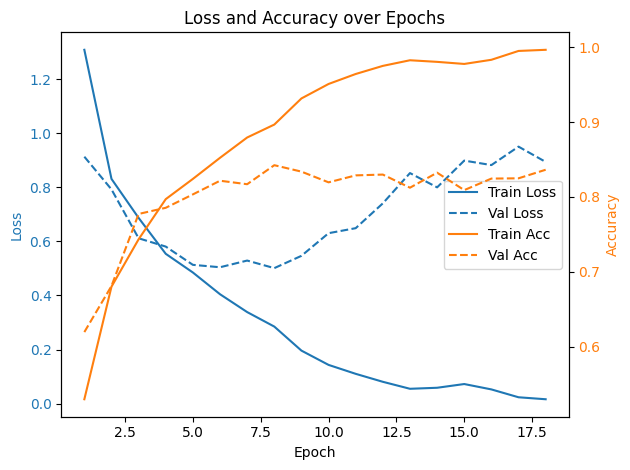

Test accuracy: 0.8202
Detected 6 classes: [0 1 2 3 4 5]


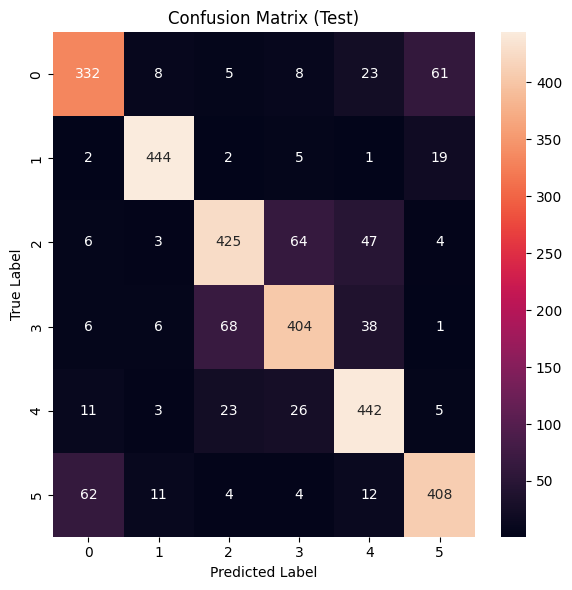

In [ ]:
class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(256 * 18 * 18, 512),
            nn.ReLU(),
            nn.Linear(512, 6)
        )
    def forward(self, x):
        return self.net(x)

name = "CNN2"
model = CNN2().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100
criterion = nn.CrossEntropyLoss()
history = {
    "train_loss": [], "train_acc": [],
    "val_loss":   [], "val_acc":   []
}

train(name, model, optimizer, epochs, criterion, history)
display_results("models/CNN2.pth", model)
# 9 min on A100 with batch size = 128, val loss = 1.7938, val acc = 0.1673

## 3rd Model

Epoch 01 | train: loss=1.1930, acc=0.5462 | val: loss=0.9110, acc=0.6648 | time: 40.25s
  -> New best val_loss 0.9110 at epoch 1. Saved to best.pt.
Epoch 02 | train: loss=0.7839, acc=0.7064 | val: loss=0.6986, acc=0.7362 | time: 40.78s
  -> New best val_loss 0.6986 at epoch 2. Saved to best.pt.
Epoch 03 | train: loss=0.6490, acc=0.7577 | val: loss=0.5753, acc=0.7949 | time: 40.94s
  -> New best val_loss 0.5753 at epoch 3. Saved to best.pt.
Epoch 04 | train: loss=0.5495, acc=0.7975 | val: loss=0.5623, acc=0.7956 | time: 40.67s
  -> New best val_loss 0.5623 at epoch 4. Saved to best.pt.
Epoch 05 | train: loss=0.4564, acc=0.8367 | val: loss=0.5520, acc=0.8045 | time: 41.27s
  -> New best val_loss 0.5520 at epoch 5. Saved to best.pt.
Epoch 06 | train: loss=0.3700, acc=0.8661 | val: loss=0.6178, acc=0.7888 | time: 40.85s
Epoch 07 | train: loss=0.3076, acc=0.8898 | val: loss=0.5161, acc=0.8274 | time: 39.65s
  -> New best val_loss 0.5161 at epoch 7. Saved to best.pt.
Epoch 08 | train: loss=0

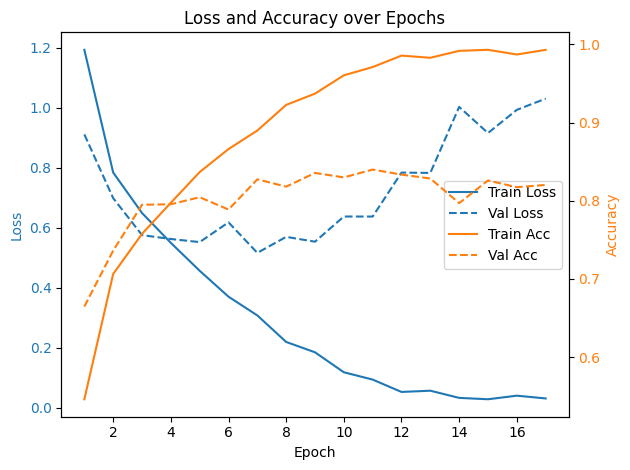

Test accuracy: 0.8062
Detected 6 classes: [0 1 2 3 4 5]


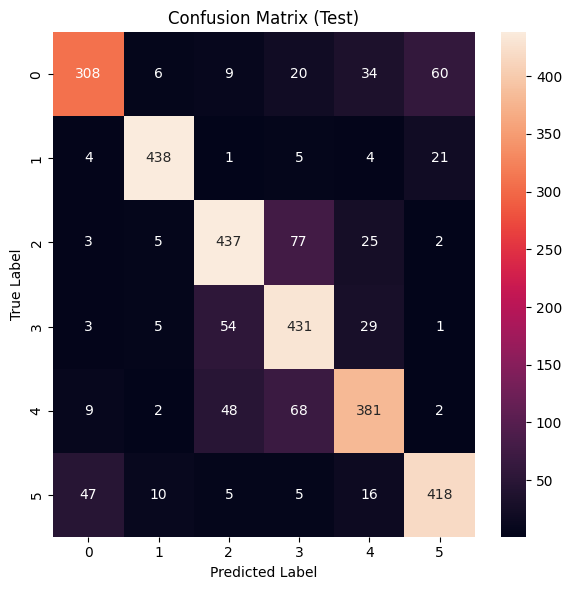

In [ ]:
class CNN3(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(256 * 18 * 18, 512),
            nn.ReLU(),
            nn.Linear(512, 6)
        )
    def forward(self, x):
        return self.net(x)

name = "CNN3"
model = CNN3().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100
criterion = nn.CrossEntropyLoss()
history = {
    "train_loss": [], "train_acc": [],
    "val_loss":   [], "val_acc":   []
}

train(name, model, optimizer, epochs, criterion, history)
display_results("models/CNN3.pth", model)

## 4th model

Epoch 01 | train: loss=1.4530, acc=0.5140 | val: loss=1.0105, acc=0.6101 | time: 43.21s
  -> New best val_loss 1.0105 at epoch 1. Saved to best.pt.
Epoch 02 | train: loss=0.8955, acc=0.6484 | val: loss=0.8994, acc=0.6673 | time: 44.15s
  -> New best val_loss 0.8994 at epoch 2. Saved to best.pt.
Epoch 03 | train: loss=0.7557, acc=0.7121 | val: loss=0.8554, acc=0.6783 | time: 44.11s
  -> New best val_loss 0.8554 at epoch 3. Saved to best.pt.
Epoch 04 | train: loss=0.7005, acc=0.7349 | val: loss=0.6705, acc=0.7552 | time: 44.40s
  -> New best val_loss 0.6705 at epoch 4. Saved to best.pt.
Epoch 05 | train: loss=0.6041, acc=0.7755 | val: loss=0.6079, acc=0.7834 | time: 44.73s
  -> New best val_loss 0.6079 at epoch 5. Saved to best.pt.
Epoch 06 | train: loss=0.5262, acc=0.8032 | val: loss=0.6090, acc=0.7823 | time: 44.74s
Epoch 07 | train: loss=0.4836, acc=0.8183 | val: loss=0.6410, acc=0.7773 | time: 43.18s
Epoch 08 | train: loss=0.3744, acc=0.8639 | val: loss=0.6199, acc=0.7916 | time: 43.

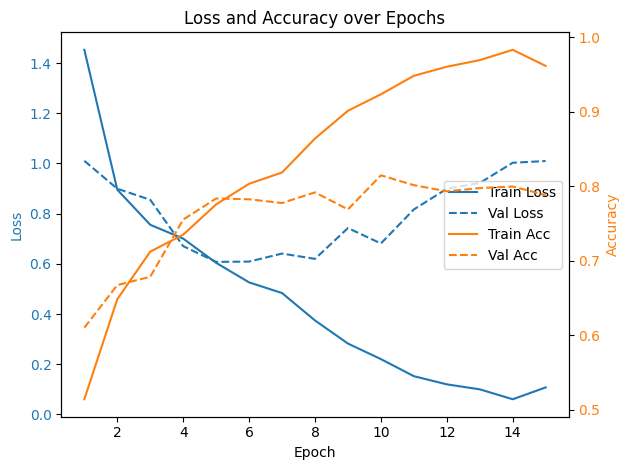

Test accuracy: 0.7745
Detected 6 classes: [0 1 2 3 4 5]


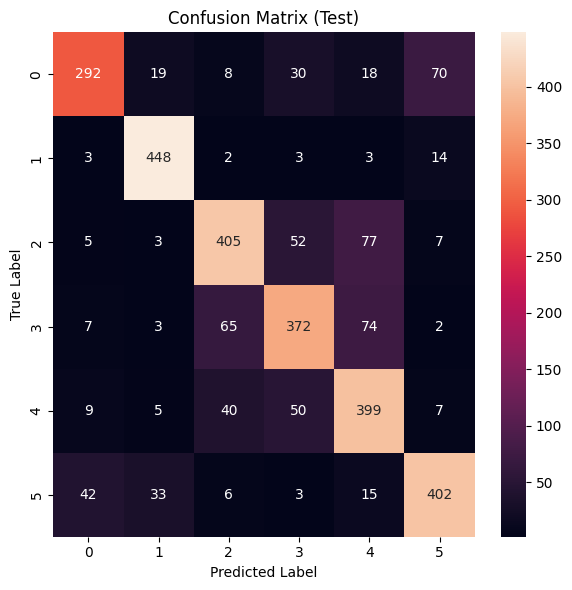

In [ ]:
class CNN4(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(256 * 18 * 18, 512),
            nn.ReLU(),
            nn.Linear(512, 6)
        )
    def forward(self, x):
        return self.net(x)

name = "CNN4"
model = CNN4().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100
criterion = nn.CrossEntropyLoss()
history = {
    "train_loss": [], "train_acc": [],
    "val_loss":   [], "val_acc":   []
}

train(name, model, optimizer, epochs, criterion, history)
display_results("models/CNN4.pth", model)

## 5th Model

Epoch 01 | train: loss=1.7121, acc=0.3081 | val: loss=1.4618, acc=0.4929 | time: 42.20s
  -> New best val_loss 1.4618 at epoch 1. Saved to best.pt.
Epoch 02 | train: loss=1.3736, acc=0.4727 | val: loss=1.2907, acc=0.4882 | time: 42.73s
  -> New best val_loss 1.2907 at epoch 2. Saved to best.pt.
Epoch 03 | train: loss=1.1771, acc=0.5426 | val: loss=1.2341, acc=0.5311 | time: 42.49s
  -> New best val_loss 1.2341 at epoch 3. Saved to best.pt.
Epoch 04 | train: loss=1.0996, acc=0.5660 | val: loss=1.1350, acc=0.5393 | time: 42.68s
  -> New best val_loss 1.1350 at epoch 4. Saved to best.pt.
Epoch 05 | train: loss=1.0513, acc=0.5924 | val: loss=1.0577, acc=0.5904 | time: 41.78s
  -> New best val_loss 1.0577 at epoch 5. Saved to best.pt.
Epoch 06 | train: loss=1.0172, acc=0.6044 | val: loss=1.1416, acc=0.5622 | time: 41.77s
Epoch 07 | train: loss=0.9885, acc=0.6158 | val: loss=1.0320, acc=0.6079 | time: 41.78s
  -> New best val_loss 1.0320 at epoch 7. Saved to best.pt.
Epoch 08 | train: loss=0

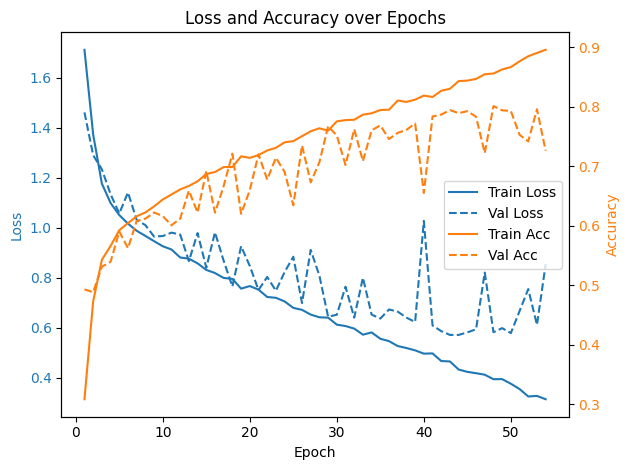

Test accuracy: 0.7878
Detected 6 classes: [0 1 2 3 4 5]


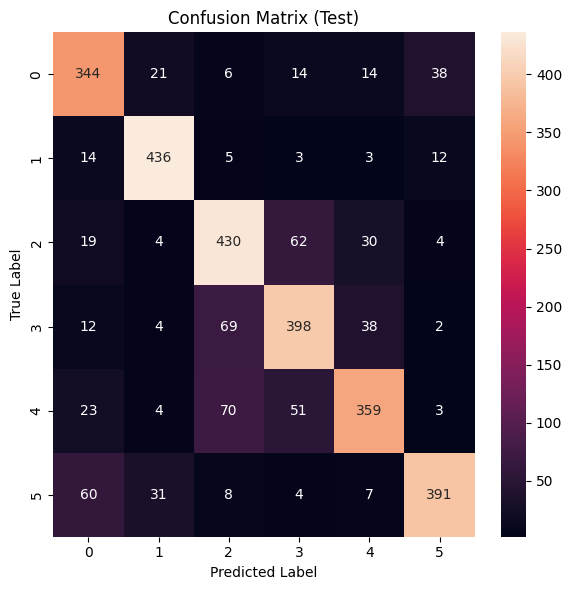

In [ ]:
class CNN5(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(256 * 18 * 18, 512),
            nn.ReLU(),
            nn.Linear(512, 6)
        )
    def forward(self, x):
        return self.net(x)

name = "CNN5"
model = CNN5().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
epochs = 100
criterion = nn.CrossEntropyLoss()
history = {
    "train_loss": [], "train_acc": [],
    "val_loss":   [], "val_acc":   []
}

train(name, model, optimizer, epochs, criterion, history)
display_results("models/CNN5.pth", model)

## 6th Model

Epoch 01 | train: loss=1.7884, acc=0.1692 | val: loss=1.7844, acc=0.2984 | time: 43.02s
  -> New best val_loss 1.7844 at epoch 1. Saved to best.pt.
Epoch 02 | train: loss=1.7797, acc=0.3279 | val: loss=1.7755, acc=0.2959 | time: 43.01s
  -> New best val_loss 1.7755 at epoch 2. Saved to best.pt.
Epoch 03 | train: loss=1.7690, acc=0.2977 | val: loss=1.7627, acc=0.2856 | time: 42.34s
  -> New best val_loss 1.7627 at epoch 3. Saved to best.pt.
Epoch 04 | train: loss=1.7531, acc=0.2976 | val: loss=1.7422, acc=0.3095 | time: 43.16s
  -> New best val_loss 1.7422 at epoch 4. Saved to best.pt.
Epoch 05 | train: loss=1.7274, acc=0.3397 | val: loss=1.7076, acc=0.3781 | time: 42.82s
  -> New best val_loss 1.7076 at epoch 5. Saved to best.pt.
Epoch 06 | train: loss=1.6832, acc=0.4086 | val: loss=1.6477, acc=0.4264 | time: 42.34s
  -> New best val_loss 1.6477 at epoch 6. Saved to best.pt.
Epoch 07 | train: loss=1.6067, acc=0.4475 | val: loss=1.5456, acc=0.4818 | time: 43.29s
  -> New best val_loss 1

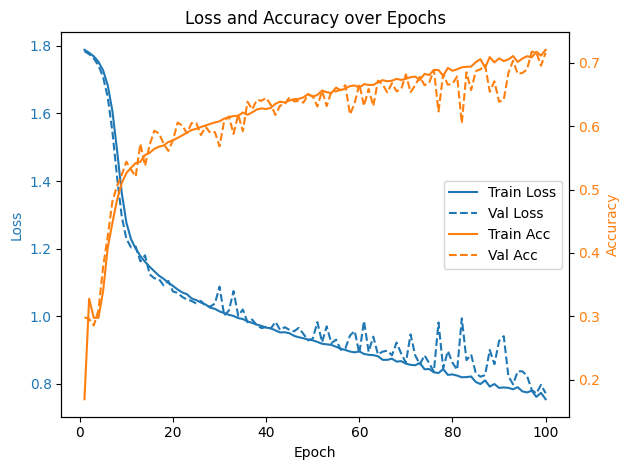

Test accuracy: 0.7083
Detected 6 classes: [0 1 2 3 4 5]


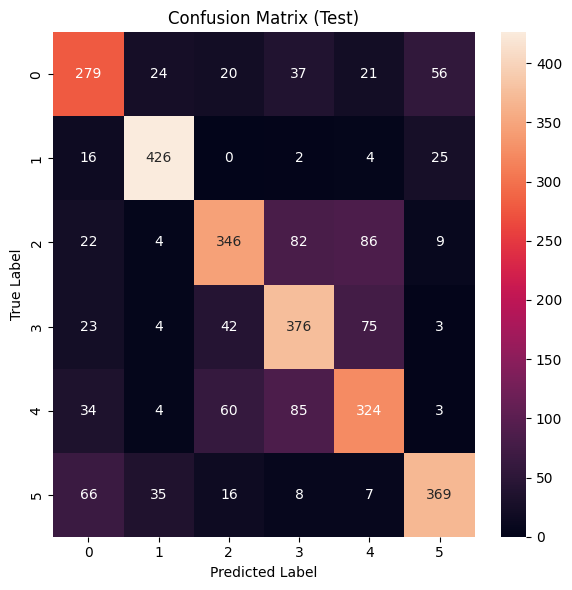

In [ ]:
class CNN6(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(256 * 18 * 18, 512),
            nn.ReLU(),
            nn.Linear(512, 6)
        )
    def forward(self, x):
        return self.net(x)

name = "CNN6"
model = CNN6().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001)
epochs = 100
criterion = nn.CrossEntropyLoss()
history = {
    "train_loss": [], "train_acc": [],
    "val_loss":   [], "val_acc":   []
}

train(name, model, optimizer, epochs, criterion, history)
display_results("models/CNN6.pth", model)

## 7th Model

Epoch 01 | train: loss=1.1349, acc=0.5619 | val: loss=0.9323, acc=0.6437 | time: 55.12s
  -> New best val_loss 0.9323 at epoch 1. Saved to best.pt.
Epoch 02 | train: loss=0.8425, acc=0.6904 | val: loss=0.7932, acc=0.7009 | time: 43.79s
  -> New best val_loss 0.7932 at epoch 2. Saved to best.pt.
Epoch 03 | train: loss=0.7134, acc=0.7363 | val: loss=0.6863, acc=0.7555 | time: 43.14s
  -> New best val_loss 0.6863 at epoch 3. Saved to best.pt.
Epoch 04 | train: loss=0.6240, acc=0.7727 | val: loss=0.6804, acc=0.7502 | time: 43.08s
  -> New best val_loss 0.6804 at epoch 4. Saved to best.pt.
Epoch 05 | train: loss=0.5381, acc=0.8033 | val: loss=0.5578, acc=0.8027 | time: 43.36s
  -> New best val_loss 0.5578 at epoch 5. Saved to best.pt.
Epoch 06 | train: loss=0.4953, acc=0.8232 | val: loss=0.5485, acc=0.8059 | time: 43.27s
  -> New best val_loss 0.5485 at epoch 6. Saved to best.pt.
Epoch 07 | train: loss=0.4287, acc=0.8500 | val: loss=0.5291, acc=0.8084 | time: 43.86s
  -> New best val_loss 0

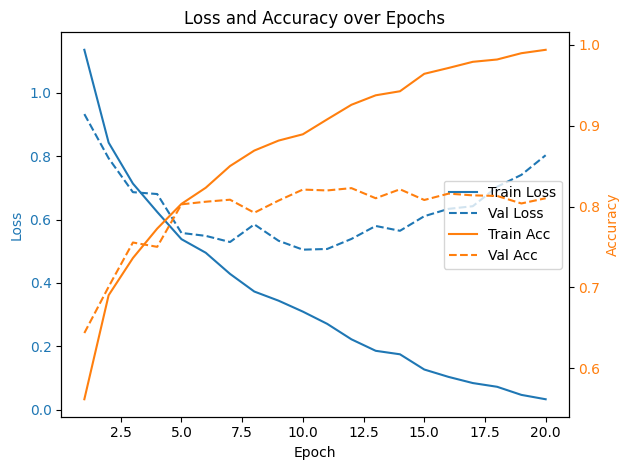

Test accuracy: 0.8169
Detected 6 classes: [0 1 2 3 4 5]


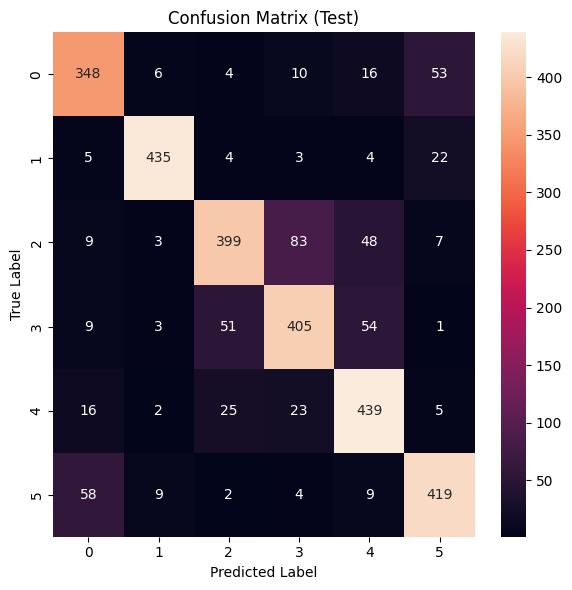

In [ ]:
class CNN7(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(256 * 18 * 18, 512),
            nn.ReLU(),
            nn.Linear(512, 6)
        )
    def forward(self, x):
        return self.net(x)

name = "CNN7"
model = CNN7().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 100
criterion = nn.CrossEntropyLoss()
history = {
    "train_loss": [], "train_acc": [],
    "val_loss":   [], "val_acc":   []
}

train(name, model, optimizer, epochs, criterion, history)
display_results("models/CNN7.pth", model)

## 8th Model

Epoch 01 | train: loss=1.3826, acc=0.4880 | val: loss=0.9700, acc=0.6036 | time: 45.02s
  -> New best val_loss 0.9700 at epoch 1. Saved to best.pt.
Epoch 02 | train: loss=0.8888, acc=0.6514 | val: loss=0.8036, acc=0.6783 | time: 47.18s
  -> New best val_loss 0.8036 at epoch 2. Saved to best.pt.
Epoch 03 | train: loss=0.7648, acc=0.7146 | val: loss=0.6514, acc=0.7663 | time: 47.53s
  -> New best val_loss 0.6514 at epoch 3. Saved to best.pt.
Epoch 04 | train: loss=0.6207, acc=0.7723 | val: loss=0.6269, acc=0.7731 | time: 48.42s
  -> New best val_loss 0.6269 at epoch 4. Saved to best.pt.
Epoch 05 | train: loss=0.4804, acc=0.8267 | val: loss=0.5806, acc=0.7866 | time: 47.28s
  -> New best val_loss 0.5806 at epoch 5. Saved to best.pt.
Epoch 06 | train: loss=0.3763, acc=0.8663 | val: loss=0.6191, acc=0.7934 | time: 46.27s
Epoch 07 | train: loss=0.2845, acc=0.9001 | val: loss=0.6783, acc=0.7827 | time: 44.28s
Epoch 08 | train: loss=0.1930, acc=0.9359 | val: loss=0.7269, acc=0.7991 | time: 44.

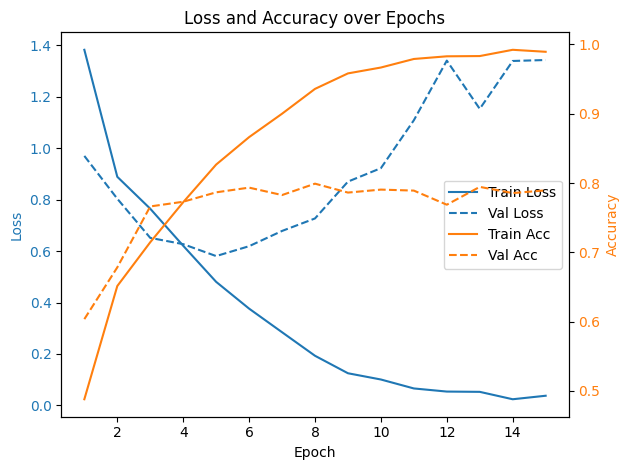

Test accuracy: 0.7872
Detected 6 classes: [0 1 2 3 4 5]


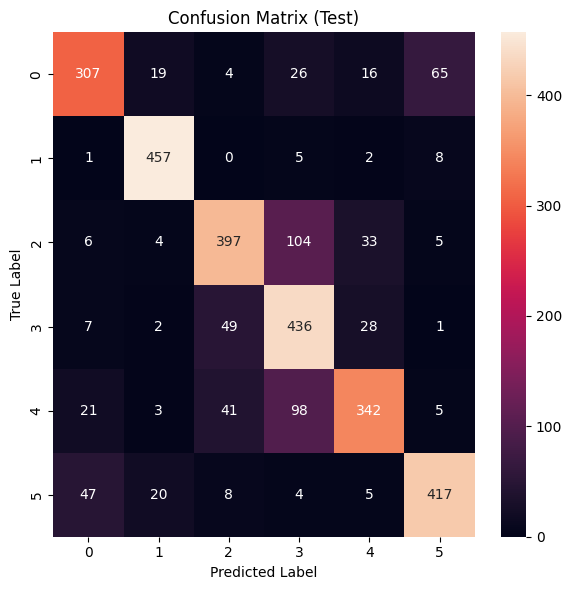

In [ ]:
class CNN8(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(256 * 18 * 18, 4096),
            nn.ReLU(),
            nn.Linear(4096, 256),
            nn.ReLU(),
            nn.Linear(256, 6)
        )
    def forward(self, x):
        return self.net(x)

name = "CNN8"
model = CNN8().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100
criterion = nn.CrossEntropyLoss()
history = {
    "train_loss": [], "train_acc": [],
    "val_loss":   [], "val_acc":   []
}

train(name, model, optimizer, epochs, criterion, history)
display_results("models/CNN8.pth", model)

## 9th Model

Epoch 01 | train: loss=1.5107, acc=0.4977 | val: loss=0.9682, acc=0.6204 | time: 41.50s
  -> New best val_loss 0.9682 at epoch 1. Saved to best.pt.
Epoch 02 | train: loss=0.8876, acc=0.6551 | val: loss=0.8818, acc=0.6608 | time: 44.00s
  -> New best val_loss 0.8818 at epoch 2. Saved to best.pt.
Epoch 03 | train: loss=0.7695, acc=0.7083 | val: loss=0.8508, acc=0.6773 | time: 44.06s
  -> New best val_loss 0.8508 at epoch 3. Saved to best.pt.
Epoch 04 | train: loss=0.6707, acc=0.7491 | val: loss=0.7206, acc=0.7380 | time: 44.37s
  -> New best val_loss 0.7206 at epoch 4. Saved to best.pt.
Epoch 05 | train: loss=0.5724, acc=0.7921 | val: loss=0.7143, acc=0.7362 | time: 44.49s
  -> New best val_loss 0.7143 at epoch 5. Saved to best.pt.
Epoch 06 | train: loss=0.5047, acc=0.8143 | val: loss=0.6693, acc=0.7598 | time: 44.00s
  -> New best val_loss 0.6693 at epoch 6. Saved to best.pt.
Epoch 07 | train: loss=0.4247, acc=0.8509 | val: loss=0.7448, acc=0.7495 | time: 44.36s
Epoch 08 | train: loss=0

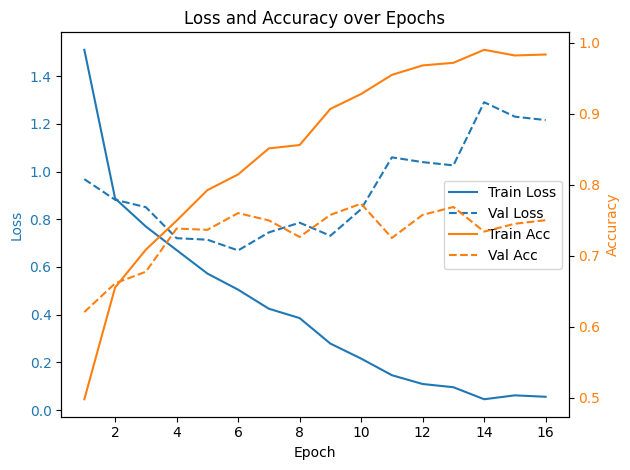

Test accuracy: 0.7564
Detected 6 classes: [0 1 2 3 4 5]


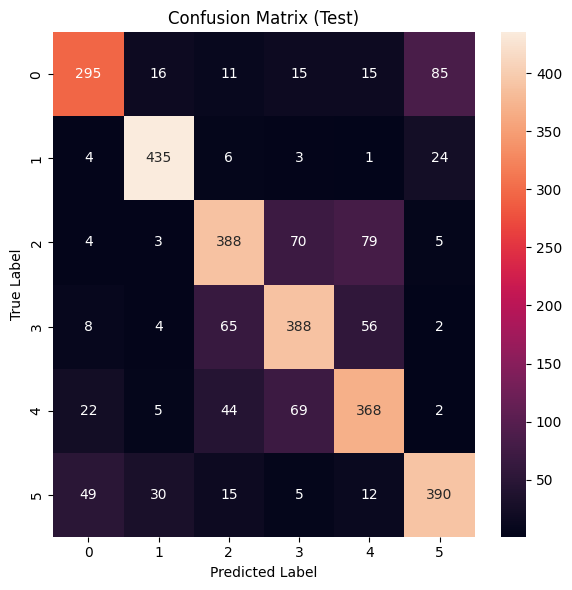

In [ ]:
class CNN9(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(128 * 37 * 37, 512),
            nn.ReLU(),
            nn.Linear(512, 6)
        )
    def forward(self, x):
        return self.net(x)

name = "CNN9"
model = CNN9().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100
criterion = nn.CrossEntropyLoss()
history = {
    "train_loss": [], "train_acc": [],
    "val_loss":   [], "val_acc":   []
}

train(name, model, optimizer, epochs, criterion, history)
display_results("models/CNN9.pth", model)


## 10th Model

In [12]:
# Load data
if in_colab():
    dataset = datasets.ImageFolder(root="/content/drive/MyDrive/2025-2026/Semester 1/MTH 4320/data/seg_train/seg_train/", transform=transforms.ToTensor())
    test_dataset = datasets.ImageFolder(root="/content/drive/MyDrive/2025-2026/Semester 1/MTH 4320/data/seg_test/seg_test/", transform=transforms.ToTensor())
else:
    dataset = datasets.ImageFolder(root="data/seg_train/seg_train", transform=transforms.ToTensor().Normalize())
    test_dataset = datasets.ImageFolder(root="data/seg_test/seg_test", transform=transforms.ToTensor().Normalize)

print(f"Classes: {dataset.classes}")

# Split data
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

# Data loaders
batch_size = 128
print(f"Batch size: {batch_size}")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Train size: 11188
Val size: 2798
Test size: 2993
Batch size: 128


Epoch 01 | train: loss=1.2504, acc=0.5275 | val: loss=0.9168, acc=0.6519 | time: 43.77s
  -> New best val_loss 0.9168 at epoch 1. Saved to best.pt.
Epoch 02 | train: loss=0.8211, acc=0.6882 | val: loss=0.7611, acc=0.7087 | time: 43.89s
  -> New best val_loss 0.7611 at epoch 2. Saved to best.pt.
Epoch 03 | train: loss=0.7016, acc=0.7342 | val: loss=0.6267, acc=0.7731 | time: 44.22s
  -> New best val_loss 0.6267 at epoch 3. Saved to best.pt.
Epoch 04 | train: loss=0.5780, acc=0.7862 | val: loss=0.5971, acc=0.7781 | time: 43.61s
  -> New best val_loss 0.5971 at epoch 4. Saved to best.pt.
Epoch 05 | train: loss=0.4839, acc=0.8214 | val: loss=0.5455, acc=0.7959 | time: 43.78s
  -> New best val_loss 0.5455 at epoch 5. Saved to best.pt.
Epoch 06 | train: loss=0.4155, acc=0.8495 | val: loss=0.6004, acc=0.7852 | time: 43.52s
Epoch 07 | train: loss=0.3530, acc=0.8724 | val: loss=0.6666, acc=0.7745 | time: 42.22s
Epoch 08 | train: loss=0.2881, acc=0.8957 | val: loss=0.6047, acc=0.7920 | time: 42.

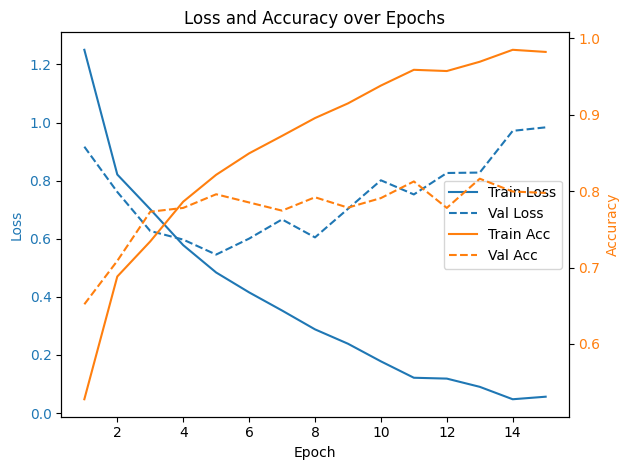

Test accuracy: 0.8069
Detected 6 classes: [0 1 2 3 4 5]


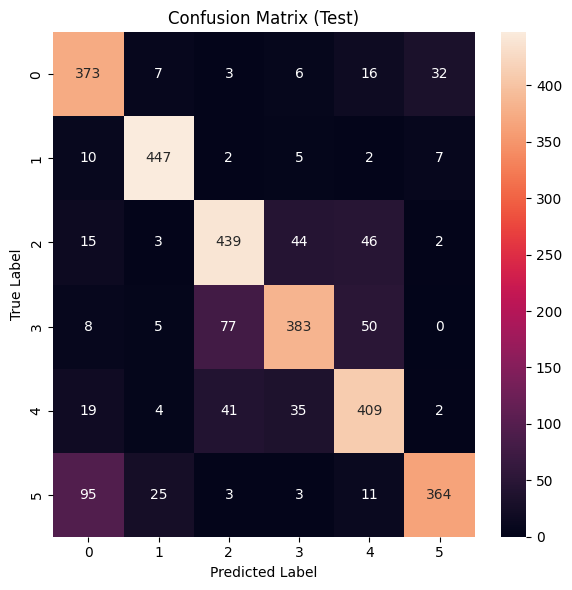

In [13]:
class CNN10(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(256 * 18 * 18, 512),
            nn.ReLU(),
            nn.Linear(512, 6)
        )
    def forward(self, x):
        return self.net(x)

name = "CNN10"
model = CNN10().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100
criterion = nn.CrossEntropyLoss()
history = {
    "train_loss": [], "train_acc": [],
    "val_loss":   [], "val_acc":   []
}

train(name, model, optimizer, epochs, criterion, history)
display_results("models/CNN10.pth", model)

## 1st Pretrained Model

Epoch 01 | train: loss=0.8410, acc=0.7532 | val: loss=0.5156, acc=0.8435 | time: 39.29s
  -> New best val_loss 0.5156 at epoch 1. Saved to best.pt.
Epoch 02 | train: loss=0.4805, acc=0.8454 | val: loss=0.4353, acc=0.8599 | time: 39.04s
  -> New best val_loss 0.4353 at epoch 2. Saved to best.pt.
Epoch 03 | train: loss=0.4263, acc=0.8554 | val: loss=0.4042, acc=0.8599 | time: 39.03s
  -> New best val_loss 0.4042 at epoch 3. Saved to best.pt.
Epoch 04 | train: loss=0.3904, acc=0.8641 | val: loss=0.3841, acc=0.8678 | time: 38.86s
  -> New best val_loss 0.3841 at epoch 4. Saved to best.pt.
Epoch 05 | train: loss=0.3743, acc=0.8657 | val: loss=0.3769, acc=0.8738 | time: 39.16s
  -> New best val_loss 0.3769 at epoch 5. Saved to best.pt.
Epoch 06 | train: loss=0.3591, acc=0.8741 | val: loss=0.3716, acc=0.8724 | time: 38.51s
  -> New best val_loss 0.3716 at epoch 6. Saved to best.pt.
Epoch 07 | train: loss=0.3502, acc=0.8746 | val: loss=0.3712, acc=0.8735 | time: 39.40s
  -> New best val_loss 0

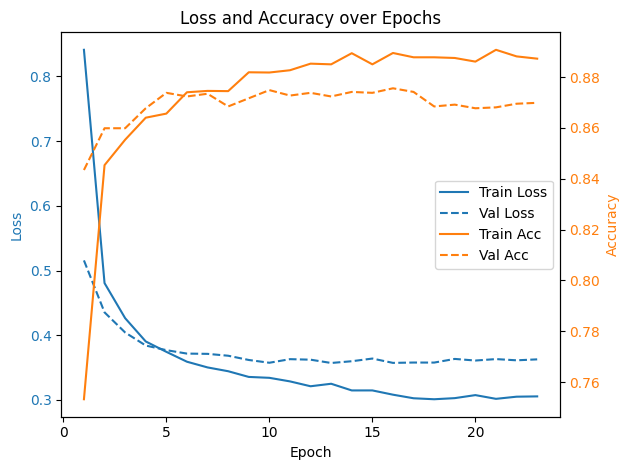

Test accuracy: 0.8767
Detected 6 classes: [0 1 2 3 4 5]


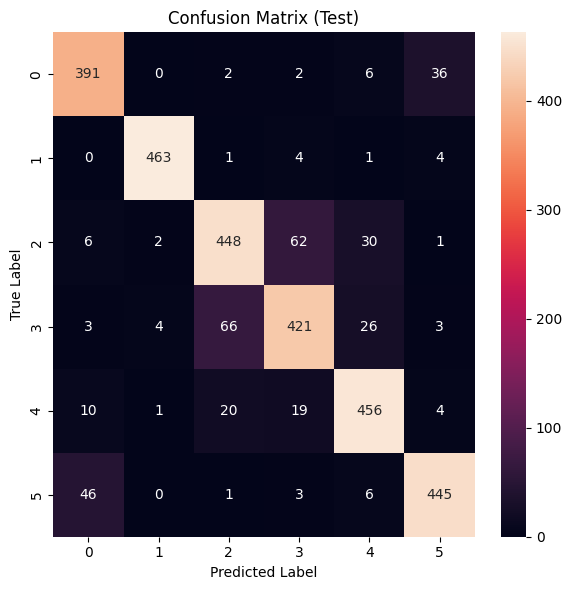

In [20]:
name = "Pretrained1"
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 6)

optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100
criterion = nn.CrossEntropyLoss()
history = {
    "train_loss": [], "train_acc": [],
    "val_loss":   [], "val_acc":   []
}

# Freeze all layers
for parameter in model.parameters():
    parameter.requires_grad = False
# Unfreeze head
for parameter in model.classifier[1].parameters():
    parameter.requires_grad = True

model = model.to(device)
train(name, model, optimizer, epochs, criterion, history)
display_results("models/Pretrained1.pth", model)

In [23]:
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## 2nd Pretrained Model

Epoch 01 | train: loss=1.5954, acc=0.4238 | val: loss=1.3757, acc=0.6465 | time: 39.40s
  -> New best val_loss 1.3757 at epoch 1. Saved to best.pt.
Epoch 02 | train: loss=1.2344, acc=0.7083 | val: loss=1.0862, acc=0.7627 | time: 39.02s
  -> New best val_loss 1.0862 at epoch 2. Saved to best.pt.
Epoch 03 | train: loss=1.0065, acc=0.7768 | val: loss=0.9110, acc=0.8006 | time: 39.74s
  -> New best val_loss 0.9110 at epoch 3. Saved to best.pt.
Epoch 04 | train: loss=0.8644, acc=0.8037 | val: loss=0.7960, acc=0.8113 | time: 39.13s
  -> New best val_loss 0.7960 at epoch 4. Saved to best.pt.
Epoch 05 | train: loss=0.7682, acc=0.8163 | val: loss=0.7165, acc=0.8217 | time: 38.77s
  -> New best val_loss 0.7165 at epoch 5. Saved to best.pt.
Epoch 06 | train: loss=0.6978, acc=0.8274 | val: loss=0.6591, acc=0.8267 | time: 39.18s
  -> New best val_loss 0.6591 at epoch 6. Saved to best.pt.
Epoch 07 | train: loss=0.6515, acc=0.8267 | val: loss=0.6161, acc=0.8313 | time: 39.07s
  -> New best val_loss 0

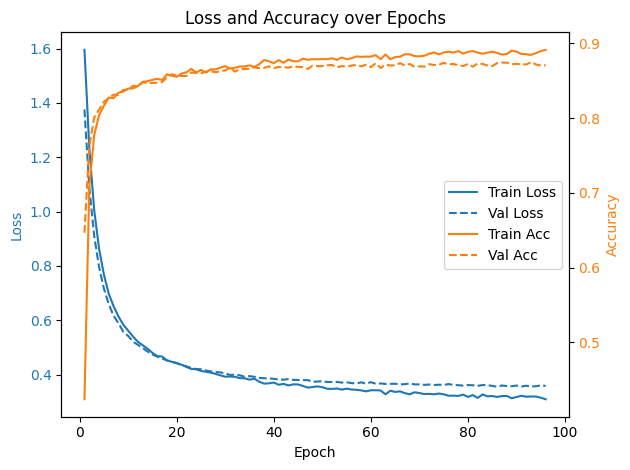

Test accuracy: 0.8747
Detected 6 classes: [0 1 2 3 4 5]


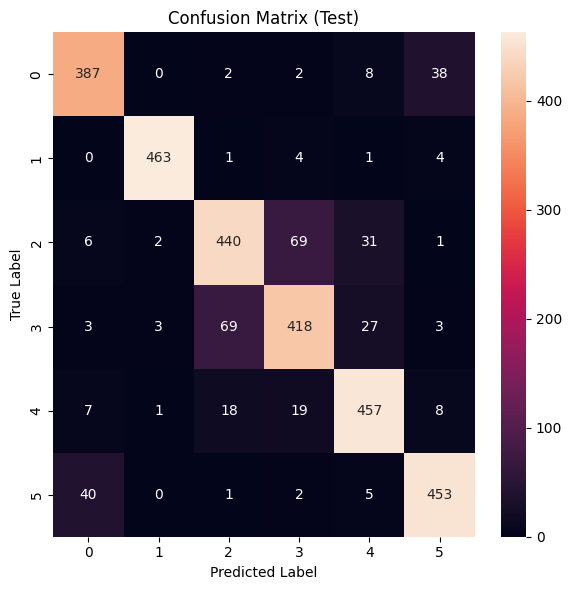

In [21]:
name = "Pretrained2"
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 6)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 100
criterion = nn.CrossEntropyLoss()
history = {
    "train_loss": [], "train_acc": [],
    "val_loss":   [], "val_acc":   []
}

# Freeze all layers
for parameter in model.parameters():
    parameter.requires_grad = False
# Unfreeze head
for parameter in model.classifier[1].parameters():
    parameter.requires_grad = True

model = model.to(device)
train(name, model, optimizer, epochs, criterion, history)
display_results("models/Pretrained2.pth", model)

## 3rd Pretrained Model

Epoch 01 | train: loss=0.5370, acc=0.8110 | val: loss=0.4343, acc=0.8556 | time: 39.56s
  -> New best val_loss 0.4343 at epoch 1. Saved to best.pt.
Epoch 02 | train: loss=0.4327, acc=0.8472 | val: loss=0.4094, acc=0.8570 | time: 40.10s
  -> New best val_loss 0.4094 at epoch 2. Saved to best.pt.
Epoch 03 | train: loss=0.4157, acc=0.8515 | val: loss=0.4365, acc=0.8517 | time: 39.27s
Epoch 04 | train: loss=0.4192, acc=0.8532 | val: loss=0.5057, acc=0.8406 | time: 39.43s
Epoch 05 | train: loss=0.4119, acc=0.8540 | val: loss=0.4452, acc=0.8556 | time: 39.55s
Epoch 06 | train: loss=0.4481, acc=0.8502 | val: loss=0.4490, acc=0.8610 | time: 39.51s
Epoch 07 | train: loss=0.4166, acc=0.8607 | val: loss=0.4493, acc=0.8581 | time: 39.13s
Epoch 08 | train: loss=0.4194, acc=0.8599 | val: loss=0.4955, acc=0.8481 | time: 39.36s
Epoch 09 | train: loss=0.4374, acc=0.8565 | val: loss=0.4930, acc=0.8445 | time: 39.35s
Epoch 10 | train: loss=0.4282, acc=0.8602 | val: loss=0.5137, acc=0.8456 | time: 39.09s


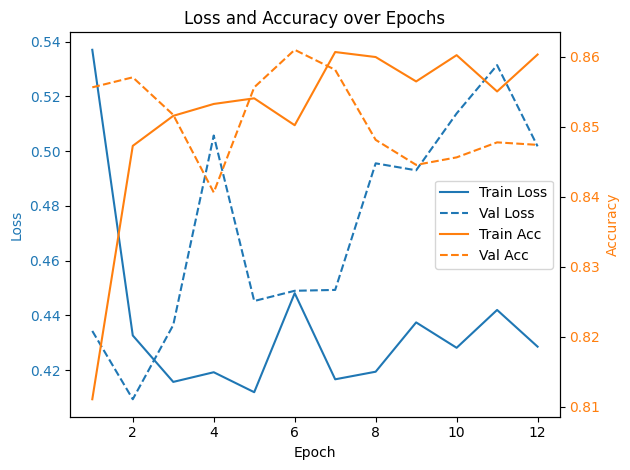

Test accuracy: 0.8550
Detected 6 classes: [0 1 2 3 4 5]


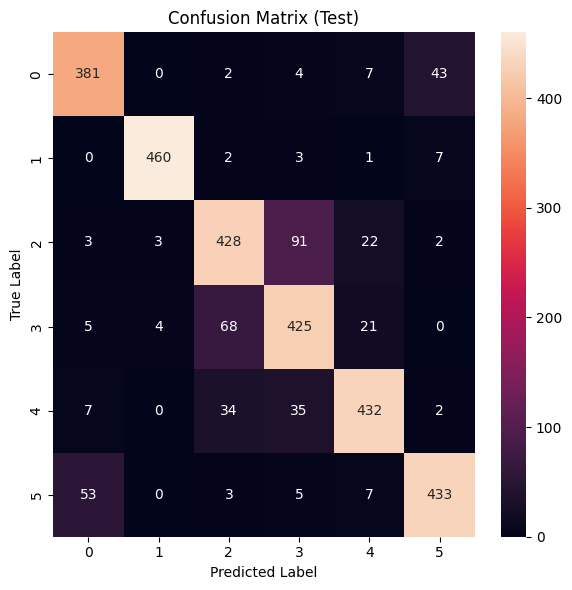

In [22]:
name = "Pretrained3"
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 6)

optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 100
criterion = nn.CrossEntropyLoss()
history = {
    "train_loss": [], "train_acc": [],
    "val_loss":   [], "val_acc":   []
}

# Freeze all layers
for parameter in model.parameters():
    parameter.requires_grad = False
# Unfreeze head
for parameter in model.classifier[1].parameters():
    parameter.requires_grad = True

model = model.to(device)
train(name, model, optimizer, epochs, criterion, history)
display_results("models/Pretrained3.pth", model)

## 4th Pretrained model

Epoch 01 | train: loss=0.5430, acc=0.8220 | val: loss=0.3338, acc=0.8760 | time: 40.07s
  -> New best val_loss 0.3338 at epoch 1. Saved to best.pt.
Epoch 02 | train: loss=0.2875, acc=0.8984 | val: loss=0.2965, acc=0.8917 | time: 39.71s
  -> New best val_loss 0.2965 at epoch 2. Saved to best.pt.
Epoch 03 | train: loss=0.2209, acc=0.9219 | val: loss=0.2864, acc=0.8928 | time: 39.69s
  -> New best val_loss 0.2864 at epoch 3. Saved to best.pt.
Epoch 04 | train: loss=0.1834, acc=0.9359 | val: loss=0.2902, acc=0.8928 | time: 39.07s
Epoch 05 | train: loss=0.1515, acc=0.9488 | val: loss=0.2829, acc=0.8978 | time: 39.71s
  -> New best val_loss 0.2829 at epoch 5. Saved to best.pt.
Epoch 06 | train: loss=0.1218, acc=0.9627 | val: loss=0.2868, acc=0.8935 | time: 39.37s
Epoch 07 | train: loss=0.1017, acc=0.9671 | val: loss=0.2899, acc=0.9003 | time: 39.87s
Epoch 08 | train: loss=0.0879, acc=0.9733 | val: loss=0.3067, acc=0.8956 | time: 39.76s
Epoch 09 | train: loss=0.0709, acc=0.9797 | val: loss=0.

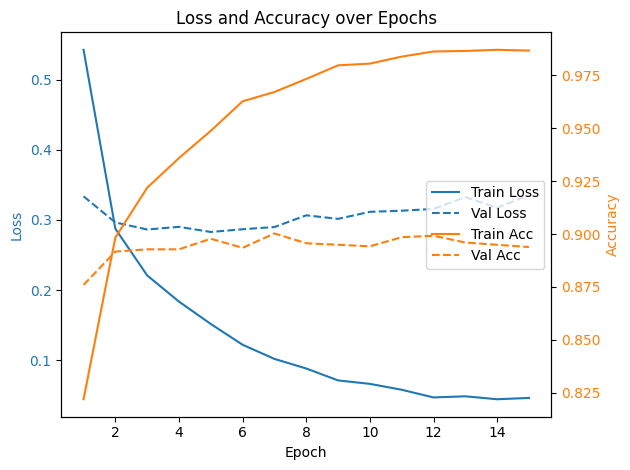

Test accuracy: 0.8981
Detected 6 classes: [0 1 2 3 4 5]


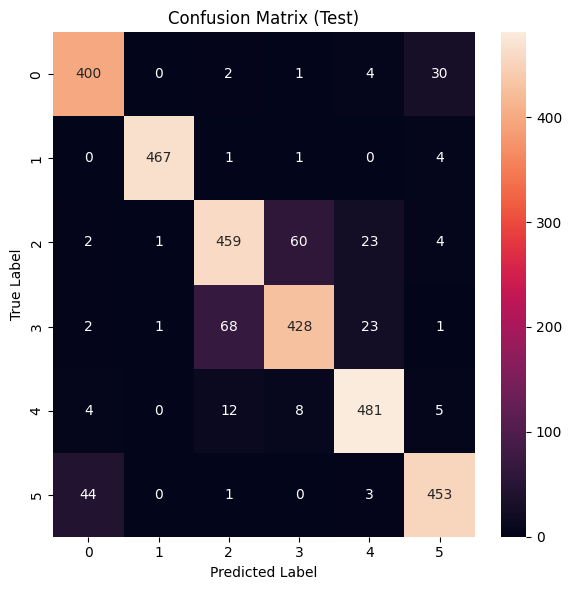

In [24]:
name = "Pretrained4"
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 6)

optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100
criterion = nn.CrossEntropyLoss()
history = {
    "train_loss": [], "train_acc": [],
    "val_loss":   [], "val_acc":   []
}

# Freeze all layers
for parameter in model.parameters():
    parameter.requires_grad = False
# Unfreeze last 2 layers
for parameter in model.classifier[1].parameters():
    parameter.requires_grad = True
for parameter in model.features[8].parameters():
    parameter.requires_grad = True

model = model.to(device)
train(name, model, optimizer, epochs, criterion, history)
display_results("models/Pretrained4.pth", model)

## 5th Pretrained model

Epoch 01 | train: loss=0.4238, acc=0.8565 | val: loss=0.2662, acc=0.9035 | time: 39.76s
  -> New best val_loss 0.2662 at epoch 1. Saved to best.pt.
Epoch 02 | train: loss=0.2029, acc=0.9271 | val: loss=0.2459, acc=0.9114 | time: 39.42s
  -> New best val_loss 0.2459 at epoch 2. Saved to best.pt.
Epoch 03 | train: loss=0.1353, acc=0.9510 | val: loss=0.2707, acc=0.9114 | time: 39.64s
Epoch 04 | train: loss=0.0946, acc=0.9672 | val: loss=0.2950, acc=0.9074 | time: 39.40s
Epoch 05 | train: loss=0.0716, acc=0.9761 | val: loss=0.3003, acc=0.9182 | time: 39.49s
Epoch 06 | train: loss=0.0617, acc=0.9790 | val: loss=0.3206, acc=0.9160 | time: 39.86s
Epoch 07 | train: loss=0.0454, acc=0.9850 | val: loss=0.3341, acc=0.9199 | time: 39.37s
Epoch 08 | train: loss=0.0354, acc=0.9885 | val: loss=0.3647, acc=0.9031 | time: 39.57s
Epoch 09 | train: loss=0.0333, acc=0.9893 | val: loss=0.3813, acc=0.9081 | time: 39.90s
Epoch 10 | train: loss=0.0337, acc=0.9888 | val: loss=0.3800, acc=0.9139 | time: 39.43s


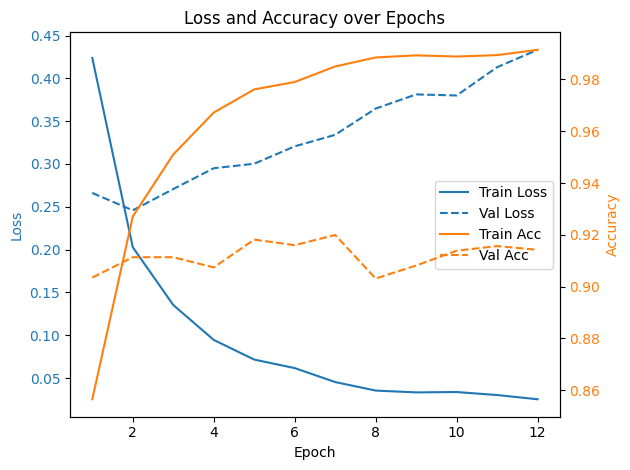

Test accuracy: 0.9081
Detected 6 classes: [0 1 2 3 4 5]


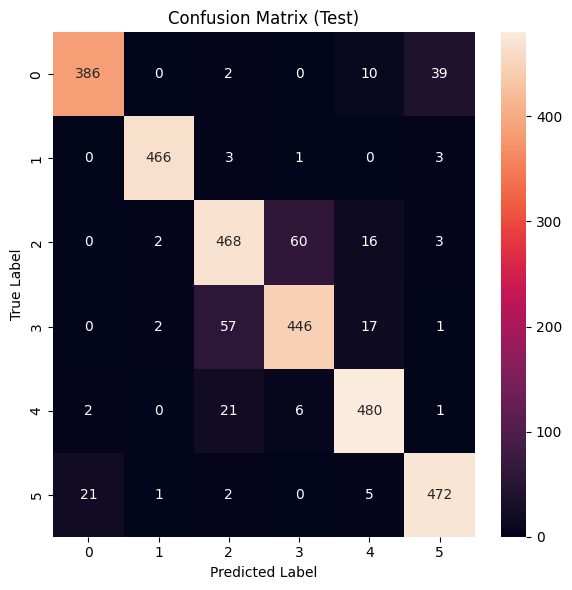

In [25]:
name = "Pretrained5"
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 6)

optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100
criterion = nn.CrossEntropyLoss()
history = {
    "train_loss": [], "train_acc": [],
    "val_loss":   [], "val_acc":   []
}

# Freeze all layers
for parameter in model.parameters():
    parameter.requires_grad = False
# Unfreeze last 2 layers
for parameter in model.classifier[1].parameters():
    parameter.requires_grad = True
for parameter in model.features[8].parameters():
    parameter.requires_grad = True
for parameter in model.features[7].parameters():
    parameter.requires_grad = True

model = model.to(device)
train(name, model, optimizer, epochs, criterion, history)
display_results("models/Pretrained5.pth", model)

## 6th Pretrained model

Epoch 01 | train: loss=0.3654, acc=0.8781 | val: loss=0.2439, acc=0.9153 | time: 39.75s
  -> New best val_loss 0.2439 at epoch 1. Saved to best.pt.
Epoch 02 | train: loss=0.1662, acc=0.9405 | val: loss=0.2150, acc=0.9307 | time: 39.93s
  -> New best val_loss 0.2150 at epoch 2. Saved to best.pt.
Epoch 03 | train: loss=0.1105, acc=0.9610 | val: loss=0.2869, acc=0.9199 | time: 40.01s
Epoch 04 | train: loss=0.0872, acc=0.9682 | val: loss=0.3039, acc=0.9053 | time: 40.05s
Epoch 05 | train: loss=0.0713, acc=0.9745 | val: loss=0.3377, acc=0.9081 | time: 40.07s
Epoch 06 | train: loss=0.0577, acc=0.9802 | val: loss=0.2850, acc=0.9182 | time: 40.73s
Epoch 07 | train: loss=0.0349, acc=0.9879 | val: loss=0.3685, acc=0.9199 | time: 39.90s
Epoch 08 | train: loss=0.0388, acc=0.9860 | val: loss=0.3873, acc=0.9196 | time: 40.54s
Epoch 09 | train: loss=0.0364, acc=0.9879 | val: loss=0.3170, acc=0.9214 | time: 39.77s
Epoch 10 | train: loss=0.0397, acc=0.9872 | val: loss=0.3902, acc=0.9214 | time: 39.80s


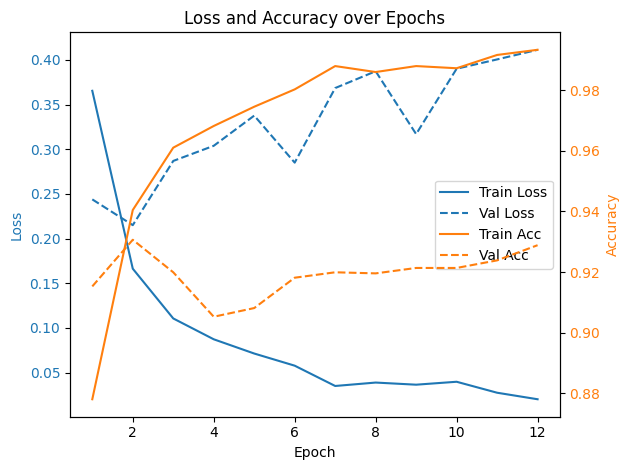

Test accuracy: 0.9262
Detected 6 classes: [0 1 2 3 4 5]


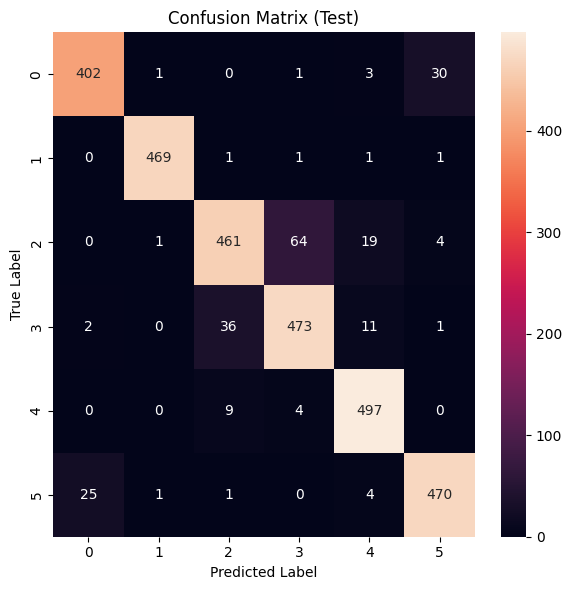

In [26]:
name = "Pretrained6"
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 6)

optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100
criterion = nn.CrossEntropyLoss()
history = {
    "train_loss": [], "train_acc": [],
    "val_loss":   [], "val_acc":   []
}

# Freeze all layers
for parameter in model.parameters():
    parameter.requires_grad = False
# Unfreeze last 2 layers
for parameter in model.classifier[1].parameters():
    parameter.requires_grad = True
for parameter in model.features[8].parameters():
    parameter.requires_grad = True
for parameter in model.features[7].parameters():
    parameter.requires_grad = True
for parameter in model.features[6].parameters():
    parameter.requires_grad = True
model = model.to(device)
train(name, model, optimizer, epochs, criterion, history)
display_results("models/Pretrained6.pth", model)

## 7th Pretrained model

Epoch 01 | train: loss=0.3548, acc=0.8788 | val: loss=0.2431, acc=0.9171 | time: 41.17s
  -> New best val_loss 0.2431 at epoch 1. Saved to best.pt.
Epoch 02 | train: loss=0.1589, acc=0.9449 | val: loss=0.2168, acc=0.9303 | time: 41.11s
  -> New best val_loss 0.2168 at epoch 2. Saved to best.pt.
Epoch 03 | train: loss=0.0989, acc=0.9664 | val: loss=0.2768, acc=0.9192 | time: 41.11s
Epoch 04 | train: loss=0.0837, acc=0.9723 | val: loss=0.3016, acc=0.9214 | time: 41.53s
Epoch 05 | train: loss=0.0622, acc=0.9779 | val: loss=0.3208, acc=0.9228 | time: 40.96s
Epoch 06 | train: loss=0.0509, acc=0.9828 | val: loss=0.2903, acc=0.9242 | time: 41.43s
Epoch 07 | train: loss=0.0466, acc=0.9837 | val: loss=0.3615, acc=0.9214 | time: 41.05s
Epoch 08 | train: loss=0.0511, acc=0.9826 | val: loss=0.3642, acc=0.9171 | time: 40.80s
Epoch 09 | train: loss=0.0351, acc=0.9888 | val: loss=0.3630, acc=0.9232 | time: 40.76s
Epoch 10 | train: loss=0.0331, acc=0.9886 | val: loss=0.3646, acc=0.9289 | time: 41.26s


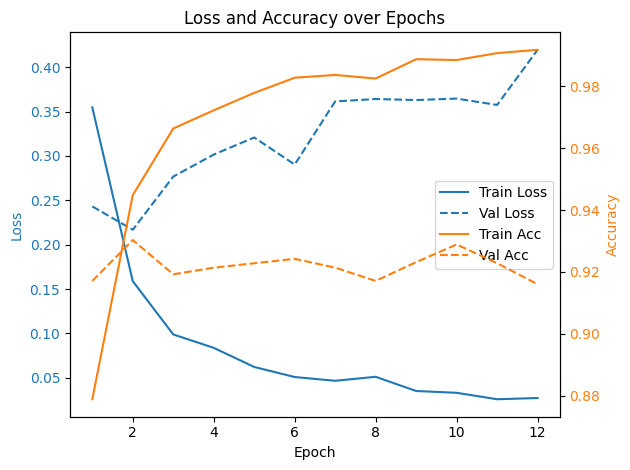

Test accuracy: 0.9282
Detected 6 classes: [0 1 2 3 4 5]


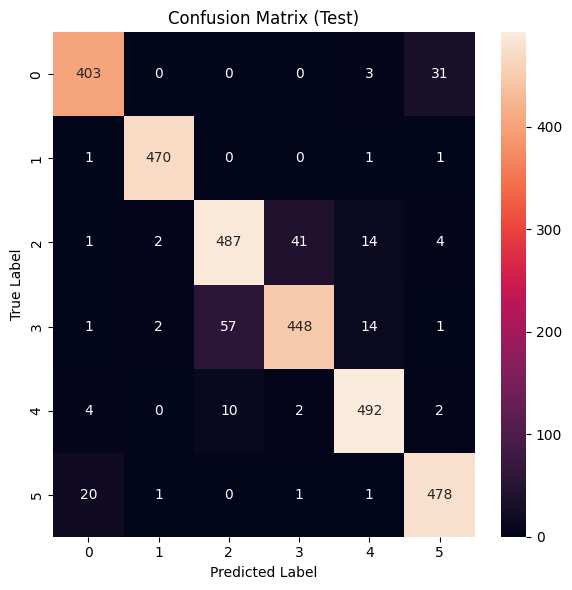

In [27]:
name = "Pretrained7"
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 6)

optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100
criterion = nn.CrossEntropyLoss()
history = {
    "train_loss": [], "train_acc": [],
    "val_loss":   [], "val_acc":   []
}

# Freeze all layers
for parameter in model.parameters():
    parameter.requires_grad = False
# Unfreeze last 2 layers
for parameter in model.classifier[1].parameters():
    parameter.requires_grad = True
for parameter in model.features[8].parameters():
    parameter.requires_grad = True
for parameter in model.features[7].parameters():
    parameter.requires_grad = True
for parameter in model.features[6].parameters():
    parameter.requires_grad = True
for parameter in model.features[5].parameters():
    parameter.requires_grad = True
model = model.to(device)
train(name, model, optimizer, epochs, criterion, history)
display_results("models/Pretrained7.pth", model)

## 8th Model

Epoch 01 | train: loss=0.3389, acc=0.8872 | val: loss=0.2297, acc=0.9253 | time: 42.81s
  -> New best val_loss 0.2297 at epoch 1. Saved to best.pt.
Epoch 02 | train: loss=0.1629, acc=0.9464 | val: loss=0.2359, acc=0.9217 | time: 43.34s
Epoch 03 | train: loss=0.1091, acc=0.9603 | val: loss=0.2748, acc=0.9153 | time: 43.00s
Epoch 04 | train: loss=0.0815, acc=0.9718 | val: loss=0.2667, acc=0.9228 | time: 42.85s
Epoch 05 | train: loss=0.0692, acc=0.9760 | val: loss=0.3072, acc=0.9210 | time: 42.65s
Epoch 06 | train: loss=0.0525, acc=0.9812 | val: loss=0.3251, acc=0.9182 | time: 42.18s
Epoch 07 | train: loss=0.0753, acc=0.9756 | val: loss=0.3547, acc=0.9185 | time: 41.90s
Epoch 08 | train: loss=0.0495, acc=0.9830 | val: loss=0.3311, acc=0.9178 | time: 42.05s
Epoch 09 | train: loss=0.0337, acc=0.9887 | val: loss=0.3227, acc=0.9282 | time: 42.37s
Epoch 10 | train: loss=0.0282, acc=0.9908 | val: loss=0.3159, acc=0.9267 | time: 42.23s
Epoch 11 | train: loss=0.0190, acc=0.9937 | val: loss=0.3792

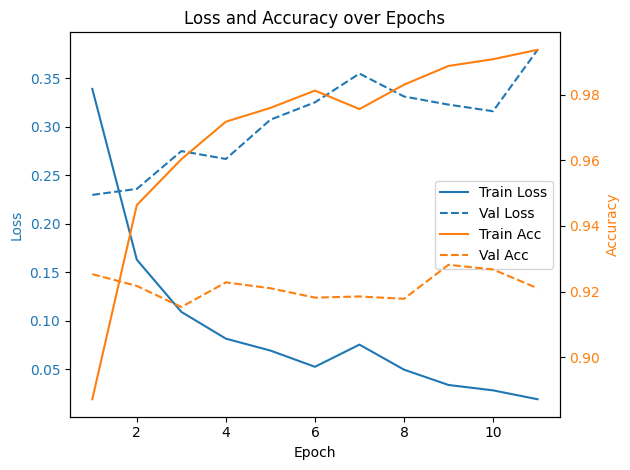

Test accuracy: 0.9188
Detected 6 classes: [0 1 2 3 4 5]


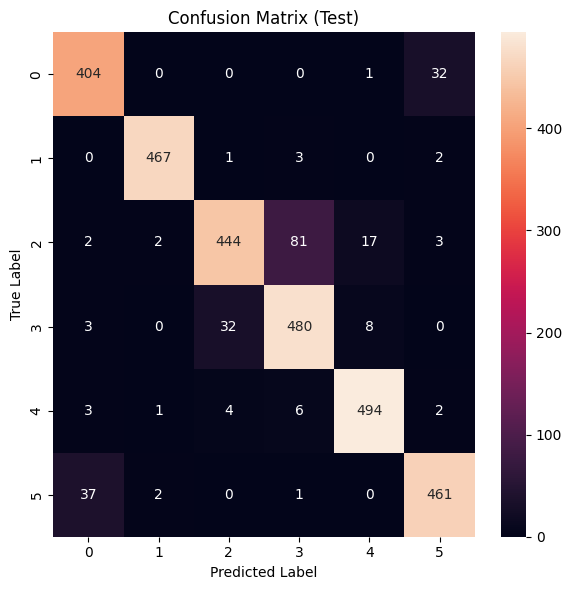

In [28]:
name = "Pretrained8"
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 6)

optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100
criterion = nn.CrossEntropyLoss()
history = {
    "train_loss": [], "train_acc": [],
    "val_loss":   [], "val_acc":   []
}

# Freeze all layers
for parameter in model.parameters():
    parameter.requires_grad = False
# Unfreeze last 2 layers
for parameter in model.classifier[1].parameters():
    parameter.requires_grad = True
for parameter in model.features[8].parameters():
    parameter.requires_grad = True
for parameter in model.features[7].parameters():
    parameter.requires_grad = True
for parameter in model.features[6].parameters():
    parameter.requires_grad = True
for parameter in model.features[5].parameters():
    parameter.requires_grad = True
for parameter in model.features[4].parameters():
    parameter.requires_grad = True
for parameter in model.features[3].parameters():
    parameter.requires_grad = True
model = model.to(device)
train(name, model, optimizer, epochs, criterion, history)
display_results("models/Pretrained8.pth", model)

## 9th Pretrained model

Epoch 01 | train: loss=0.8518, acc=0.7545 | val: loss=0.3241, acc=0.8942 | time: 39.94s
  -> New best val_loss 0.3241 at epoch 1. Saved to best.pt.
Epoch 02 | train: loss=0.2720, acc=0.9104 | val: loss=0.2413, acc=0.9203 | time: 40.05s
  -> New best val_loss 0.2413 at epoch 2. Saved to best.pt.
Epoch 03 | train: loss=0.1935, acc=0.9349 | val: loss=0.2231, acc=0.9228 | time: 40.03s
  -> New best val_loss 0.2231 at epoch 3. Saved to best.pt.
Epoch 04 | train: loss=0.1441, acc=0.9508 | val: loss=0.2203, acc=0.9239 | time: 40.15s
  -> New best val_loss 0.2203 at epoch 4. Saved to best.pt.
Epoch 05 | train: loss=0.1168, acc=0.9606 | val: loss=0.2256, acc=0.9224 | time: 40.09s
Epoch 06 | train: loss=0.0921, acc=0.9675 | val: loss=0.2324, acc=0.9274 | time: 40.17s
Epoch 07 | train: loss=0.0679, acc=0.9785 | val: loss=0.2381, acc=0.9249 | time: 40.28s
Epoch 08 | train: loss=0.0539, acc=0.9827 | val: loss=0.2440, acc=0.9253 | time: 39.84s
Epoch 09 | train: loss=0.0449, acc=0.9853 | val: loss=0.

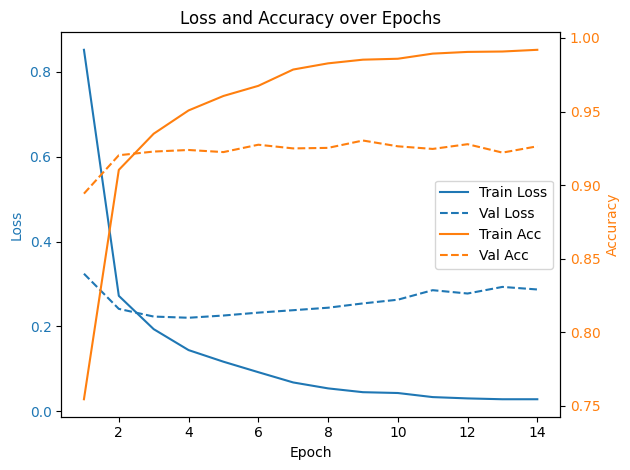

Test accuracy: 0.9208
Detected 6 classes: [0 1 2 3 4 5]


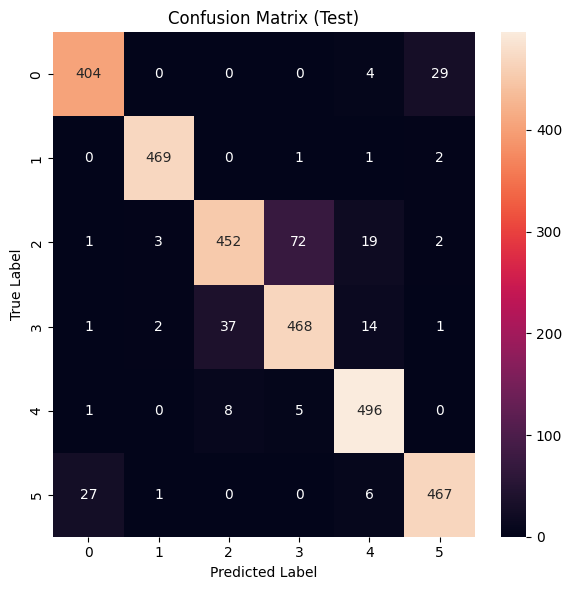

In [29]:
name = "Pretrained9"
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 6)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 100
criterion = nn.CrossEntropyLoss()
history = {
    "train_loss": [], "train_acc": [],
    "val_loss":   [], "val_acc":   []
}

# Freeze all layers
for parameter in model.parameters():
    parameter.requires_grad = False
# Unfreeze last 2 layers
for parameter in model.classifier[1].parameters():
    parameter.requires_grad = True
for parameter in model.features[8].parameters():
    parameter.requires_grad = True
for parameter in model.features[7].parameters():
    parameter.requires_grad = True
for parameter in model.features[6].parameters():
    parameter.requires_grad = True
model = model.to(device)
train(name, model, optimizer, epochs, criterion, history)
display_results("models/Pretrained9.pth", model)

## Pretrained 10

Epoch 01 | train: loss=0.7613, acc=0.7770 | val: loss=0.2711, acc=0.9103 | time: 44.33s
  -> New best val_loss 0.2711 at epoch 1. Saved to best.pt.
Epoch 02 | train: loss=0.2288, acc=0.9216 | val: loss=0.2148, acc=0.9307 | time: 44.86s
  -> New best val_loss 0.2148 at epoch 2. Saved to best.pt.
Epoch 03 | train: loss=0.1454, acc=0.9520 | val: loss=0.2114, acc=0.9282 | time: 44.23s
  -> New best val_loss 0.2114 at epoch 3. Saved to best.pt.
Epoch 04 | train: loss=0.1075, acc=0.9637 | val: loss=0.2067, acc=0.9350 | time: 44.35s
  -> New best val_loss 0.2067 at epoch 4. Saved to best.pt.
Epoch 05 | train: loss=0.0704, acc=0.9768 | val: loss=0.2258, acc=0.9335 | time: 44.31s
Epoch 06 | train: loss=0.0501, acc=0.9839 | val: loss=0.2389, acc=0.9282 | time: 44.23s
Epoch 07 | train: loss=0.0391, acc=0.9881 | val: loss=0.2496, acc=0.9346 | time: 44.35s
Epoch 08 | train: loss=0.0329, acc=0.9902 | val: loss=0.2659, acc=0.9353 | time: 44.52s
Epoch 09 | train: loss=0.0264, acc=0.9919 | val: loss=0.

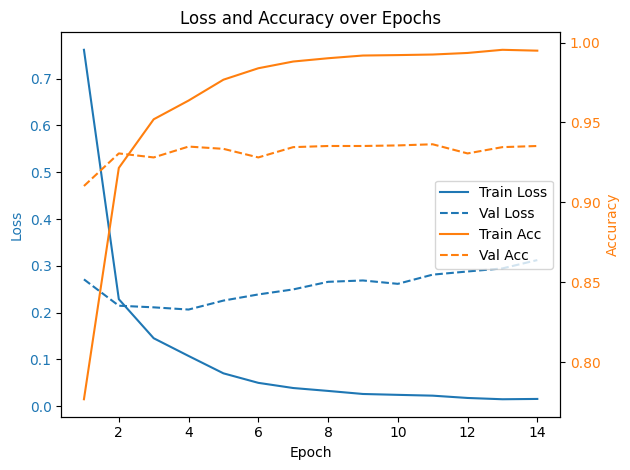

Test accuracy: 0.9298
Detected 6 classes: [0 1 2 3 4 5]


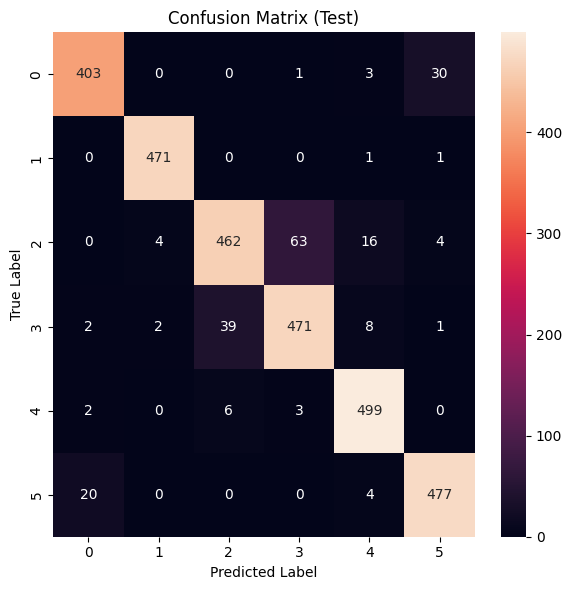

In [31]:
name = "Pretrained10"
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 6)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 100
criterion = nn.CrossEntropyLoss()
history = {
    "train_loss": [], "train_acc": [],
    "val_loss":   [], "val_acc":   []
}

model = model.to(device)
train(name, model, optimizer, epochs, criterion, history)
display_results("models/Pretrained10.pth", model)